In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter

/home/iamok/.pyenv/versions/3.11.14/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [207]:
def ngram_repetition(tokens, n=4):
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    counts = Counter(ngrams)
    # print(counts)
    total = len(ngrams)
    repeated = sum(c for c in counts.values() if c > 1)
    return repeated / total if total > 0 else 0


def weighted_same_value_count(v, n=4, gamma=0.001):
    N = v.numel()
    device = v.device
    idx = torch.arange(N, device=device)

    val_sorted, order = torch.sort(v)
    idx_sorted = idx[order]

    new_seg = torch.ones(N, dtype=torch.bool, device=device)
    new_seg[1:] = val_sorted[1:] != val_sorted[:-1]
    seg_starts = torch.nonzero(new_seg, as_tuple=False).flatten()

    # 为最后一段补一个 end
    seg_ends = torch.cat([seg_starts[1:], torch.tensor([N], device=device)])

    # 输出
    out = torch.zeros(seg_starts.shape[0], device=device, dtype=torch.float32)

    # 对每一段做全向量化计算
    for i, (s, e) in enumerate(zip(seg_starts.tolist(), seg_ends.tolist())):
        group = idx_sorted[s:e]  # 该 value 的所有位置
        gsize = group.numel()

        # pairwise |i-j|^4
        diff = group.unsqueeze(1) - group.unsqueeze(0)
        diff = diff / n
        diff[diff.abs()>1e5] = 1e5
        weights = torch.exp(-gamma * diff.pow(4))
        # sum over j for each i
        group_result = weights.sum(dim=1)

        out[i] = group_result.sum() / gsize
        # out[i] *= gsize
        # if out[i] != 0:
        #     out[i] += 1
    
    # out[torch.nonzero(out)] += 1
    # print(out)
    return out.sum() / N
    
    
def ngram_repetition_with_attention(tokens, n=4, gamma=0.001):
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    counts = Counter(ngrams)
    indices = {k:i for i, k in enumerate(counts)}
    remapped = [indices[curr] for curr in ngrams]
    # total = len(ngrams)
    total = weighted_same_value_count(torch.zeros(len(remapped), dtype=torch.long), n=n, gamma=gamma).sum().item()
    repeated = weighted_same_value_count(torch.tensor(remapped, dtype=torch.long), n=n, gamma=gamma).sum().item()
    # print(total, repeated)
    return repeated / total if total > 0 else 0

def weighted_ngram_repetition(tokens, n=4, window=50, alpha=4):
    """只惩罚近距离重复 n-gram，忽略远距离重复"""

    # 生成 n-gram 列表
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

    # 收集 n-gram 出现位置
    positions = {}
    for i, ng in enumerate(ngrams):
        positions.setdefault(ng, []).append(i)

    score = 0.0

    for ng, pos_list in positions.items():
        if len(pos_list) < 2:
            continue

        pos = torch.tensor(pos_list, dtype=torch.float32)
        diff = pos.unsqueeze(1) - pos.unsqueeze(0)    # pairwise |i - j|
        dist = diff.abs()

        # 排除对角线（i==j）
        dist = dist[dist > 0]

        # 距离越近惩罚越高，越远衰减
        weights = torch.exp(-(dist / window).pow(alpha))

        score += weights.sum().item()

    return score


In [2]:
# STAT_LOC = '/home/iamok/xlcoder/LUD Projects/MiniMind2-Small-hands-on/out'
STAT_LOC = '/home/iamok/xlcoder/LUD Projects/MiniMind2-Small-hands-on/metrics_out'
MET_LOC = STAT_LOC

In [11]:
curr = 'topp-85-anew'

In [12]:
df = pd.read_csv(os.path.join(STAT_LOC, curr+'.csv'))

In [ ]:
# df.sort_values('prompt_id').reset_index()
df

In [13]:
categories = df["prompt_id"].unique()
columns = [c for c in df.columns if c != "prompt_id"]

data = {
    col: {cat: df[df["prompt_id"] == cat][col].values for cat in categories}
    for col in columns
}


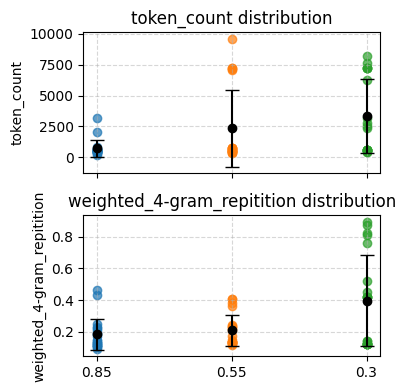

In [14]:
k = len(data)
x_positions = np.arange(len(categories))

fig, axes = plt.subplots(k, 1, figsize=(4, 2*k), sharex=True)

if k == 1:
    axes = [axes]  # 保证可循环

for idx, (col_name, col_data) in enumerate(data.items()):
    ax = axes[idx]

    # --- 绘制每个类别的散点 ---
    for i, cat in enumerate(categories):
        y = np.array(col_data[cat])

        # 散点
        ax.scatter(
            np.full(len(y), i),   # x = 类别索引
            y,
            alpha=0.7,
        )

        # --- 添加误差棒（均值 ± 标准差），可选 ---
        mean = y.mean()
        std = y.std()
        ax.errorbar(
            i,
            mean,
            yerr=std,
            fmt='o',
            color='black',
            capsize=5
        )

    ax.set_title(f"{col_name} distribution")
    ax.set_ylabel(col_name)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[-1].set_xticks(x_positions)
axes[-1].set_xticklabels(categories)

plt.tight_layout()
plt.savefig(os.path.join(MET_LOC, curr+'.png'))
plt.show()

<Figure size 640x480 with 0 Axes>

In [41]:
df.mean(0)

prompt_id              3.500000
token_count          332.098485
4-gram_repitition      0.360656
dtype: float64

In [189]:
res="""\[ C_O + O_C_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_C_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_C_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_A_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O__O_O_O_O__O__A_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O__O_O__O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O__O_O_O_O_O_O__O_O_O_O__O_O_O__O_O_O_O__O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O__O_O__O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O__O_O_O_O_O__O_O__O_O_O_O_O_O_O_O_O_O_O_O_O__O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_A_O_O__O_O____O_O_O_O_O_O_O_O_O__O_O_O_A_C_A_C_O_O_A_A_O__O_B_O__O_A_O_O_O_O__O_O_O_O_O_O_O_O__O__O__O_O_O_A_O_O__O_A_A_B_A_T_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_C_O_O_O__O__A_C_A__B_A_E_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O__O_O__O__O_O_O__O__O___O__O_O_O_O_O_O_O_O_O_C_O__A_C_A_A_T_O_O_O__O__O___O_A_O_O_O_O_O_O_O_O_C_A_O__O__A_M_A_A_O__A_C_O_O_O_A_O_O_O_O_O_O_O_O_A_O_O___O_A_O_O__A_A_A_O_C_A_A_C__O_O_O_O___O_A_A_O_O_O_O_A_C_C_O__O_O__O_A_C_O_A_O_O_O_O_O_O_O_A_O_O_O_O_A_O_O_O_O_O_O_O_O____O_A_A_O__O_A_O_O_O_O_O_O_O__O_O_O_O_O_O__O___O_O_A_O__O_O_O_O__O__O_O_O_O_O_O_A_C_A__O_O_A_O_O__A_O_O_A_C__O_O__O__O__O__A_A_O___O___A__O___O_O______O__A_O_O____O_O_O___O_O_O____O_O_O_A_A_O_O__O_O_O_O_____O___O__A_C_O_O________O__O_O_O______O_O___O_O_O_O____O_O__O_O_______C__A_O__O_____O____O__O_____O_O_O_O_O__A__O__O_O__O_O_O___O_O____________O_O_O__O___O___O_______O___O_____O____O_O_______O_____O_O__O__O_O_O__O_C_O_AO_O_O_O__O_O_O_O_O_C_O_O_O_AO_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_A_O_O_O_O_O_O_O_O_O__O_O_O__O_O_O_O_O___O_O__O____O__O__O_O_O_O_O_O___O_O_________O_O_O__O____O____O_O_O__O__O__O_O_O__O_O_O__O_O_O_O__________O__O__O__O_O__O_O__O__O_O__O_O__O_O___O_O_O_O_O_O_____O__O__O____O____O___O_O_O_O__O__O_____O_O__O__O____O_________O_O_____O__O___O_____O________O__________O______O____O___O_O______O_O____O_O___O______O_O__O____O___O____O__O_O__O__O_____O__O_O____O_O__O__O____O__O___________________O__O__O__O_O__O_O___O_____O___O_O_O__O___O_O_O__O__O_O___O__O_O__O_O_O_O_O_O_O_O_O__O__O_O_O_O__O__O__O_O_O___O__O_O_O_O_O_O_O__O_O_O______O_O_O___O___O___O____O_O_O____O__O__O____O___O__O_O_O__O__O_O_O_O_O___O__O__O_____O_O__O_O__O__O___O_____O_O_O_O__O_O___O__O_O_______O_O_O__O__O____O_O__O_O_O_O__O_O__O_O___O__O_O___O_O__O_O__O_O_O_O__O__O__O___O___O_O__O_O_O_O_O___O__O_O_O_O_O_O__O_O__O_O___O__O___O____O__O_O____O_O_O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O_O_O_O_O_O__O_O____O_O__O_O_O_O_O__O_O_O_O_O___O_O_O_O___O_O__O_O_O_O_O___O_O_O_O___O_O_O_O_O_O_O_O_O__O_O__O_O__O_O_O_O____O_O_O_O__O_O_O_O_O_O_O_O__O__O__O_O_O_O_O_O_O_O__O_O_O_O__O_O__O_O_O_O_O_O__O_O_O_O__O_O_O_O____O_O_O_O__O_O_O_O__O_O_O_O__O_O_O_O_O_O_O_O_O_O_O__O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O___O_O_O_O___O_O_O_O_O__O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O_O_O__O_O_O_O__O_O_O__O_O_O_O_O_O_O_O_O__O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O__O__O_O_O__O_O_O_O__O_O_O_O_O_O_O_O__O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_O_"""

In [187]:
res="""
下面给出一个简单且常用的 Python 斐波那契数列函数示例，你可以根据需要选择递归版、迭代版或带缓存优化的版本。

---

## ✅ **推荐：迭代版（高效、不会栈溢出）**

```python
def fibonacci(n):
    if n < 0:
        raise ValueError("n 必须是非负整数")
    if n <= 1:
        return n
    
    a, b = 0, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
    return b
```

---

## 🔁 **简单递归版（直观但效率低）**

```python
def fibonacci_recursive(n):
    if n < 0:
        raise ValueError("n 必须是非负整数")
    if n <= 1:
        return n
    return fibonacci_recursive(n - 1) + fibonacci_recursive(n - 2)
```

---

## ⚡ **带缓存的递归版（性能好）**

```python
from functools import lru_cache

@lru_cache(None)
def fibonacci_cached(n):
    if n < 0:
        raise ValueError("n 必须是非负整数")
    if n <= 1:
        return n
    return fibonacci_cached(n - 1) + fibonacci_cached(n - 2)
```

---

如果你希望我帮你写 **输出前 N 个斐波那契数** 或 **生成器版本**，可以继续告诉我！
"""

In [190]:
len(res), ngram_repetition(res,4), ngram_repetition_with_attention(res, 4), weighted_ngram_repetition(res)/(len(res)-3)

(7862, 0.9960554777961572, 0.3611227572076908, 34.16696611239052)

In [186]:
res="aaaaaaaaabbbbbbbbbb"
ngram_repetition(res), ngram_repetition_with_attention(res)

(0.88, 0.4692641165653235)